In [15]:
import re
from pathlib import Path

import numpy as np

import jax
import jax.lax
from jax.random import PRNGKey
import jax.numpy as jnp
import optax
from flax.training.train_state import TrainState
from flax import linen as nn

import matplotlib.pyplot as plt

from typing import Optional, Tuple, Dict, Any, Sequence


data_dir = "./data"
print(f"Data resides in        : {data_dir}")

Data resides in        : ./data


In [16]:
class MultiBasisDataLoader:
    def __init__(self, data_dict: dict[str, jnp.ndarray],
                 batch_size: int = 128,
                 shuffle: bool = True,
                 drop_last: bool = False,
                 seed: int = 0):
        lengths = [len(v) for v in data_dict.values()]
        if len(set(lengths)) != 1:
            raise ValueError(f"All arrays must have the same length, got: {lengths}")

        self.data = data_dict
        self.n = lengths[0]
        self.bs = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.rng = np.random.default_rng(seed)

        self.idx_slices = [
            (i, i + batch_size)
            for i in range(0, self.n, batch_size)
            if not drop_last or i + batch_size <= self.n
        ]

    def __iter__(self):
        self.order = np.arange(self.n)
        if self.shuffle:
            self.rng.shuffle(self.order)
        self.slice_idx = 0
        return self

    def __next__(self):
        if self.slice_idx >= len(self.idx_slices):
            raise StopIteration
        s, e = self.idx_slices[self.slice_idx]
        self.slice_idx += 1
        return {k: v[self.order[s:e]] for k, v in self.data.items()}


def load_measurements(folder: str, file_pattern: str = "w_*.txt") -> dict[str, jnp.ndarray]:
    out: dict[str, jnp.ndarray] = {}

    for fp in Path(folder).glob(file_pattern):
        basis = fp.stem.split("_")[2]

        bitstrings = []
        with fp.open() as f:
            for line in f:
                bitstring = np.fromiter((c.islower() for c in line.strip()), dtype=np.float32)
                bitstrings.append(bitstring)

        arr = jnp.asarray(np.stack(bitstrings))
        if basis in out:
            out[basis] = jnp.concatenate([out[basis], arr], axis=0)
        else:
            out[basis] = arr

    return out

In [17]:
data_dict = load_measurements("data/", "w_*.txt")

keys_amp = [k for k in data_dict if re.fullmatch(r"^Z+$", k)]
keys_pha = [k for k in data_dict if re.fullmatch(r"^(?!Z+$).*", k)]
dict_amp = {k: data_dict[k] for k in keys_amp}
dict_pha = {k: data_dict[k] for k in keys_pha}

loader_amp = MultiBasisDataLoader(dict_amp, batch_size=128)
loader_pha = MultiBasisDataLoader(dict_pha, batch_size=128)

In [18]:
class RBM(nn.Module):
    n_visible: int
    n_hidden: int
    k: int = 1
    n_chains: int = 1000

    @nn.compact
    def __call__(self, data_batch: jnp.ndarray, aux_vars: Optional[Dict[str, Any]] = None) -> Tuple[jnp.ndarray, Dict[str, Any]]:
        W = self.param("W", nn.initializers.normal(0.01), (self.n_visible, self.n_hidden))
        b = self.param("b", nn.initializers.zeros,        (self.n_visible,))
        c = self.param("c", nn.initializers.zeros,        (self.n_hidden,))
        key = aux_vars["key"]

        key, bern_key = jax.random.split(key, 2)
        v_chain_batch = jax.random.bernoulli(bern_key, p=0.5, shape=(self.n_chains, self.n_visible)).astype(jnp.float32)
        model_batch, key = self._gibbs_sample(W, b, c, v_chain_batch, key, k=self.k)
        model_batch = jax.lax.stop_gradient(model_batch)

        free_energy_data = self._free_energy(W, b, c, data_batch)
        free_energy_model = self._free_energy(W, b, c, model_batch)

        loss = jnp.mean(free_energy_data) - jnp.mean(free_energy_model)
        aux_vars["key"] = key

        return loss, aux_vars

    @staticmethod
    def _free_energy(W, b, c, v_batch):
        visible_term = jnp.dot(v_batch, b)
        hidden_term  = jnp.sum(jax.nn.softplus(v_batch @ W + c), axis=-1)
        free_energy = -visible_term - hidden_term
        return free_energy

    @staticmethod
    def _gibbs_step(i, state, W, b, c, T=1.0):
        v_batch, key = state
        key, h_key, v_key = jax.random.split(key, 3)

        h_logits = (v_batch @ W + c) / T
        h_probs = jax.nn.sigmoid(h_logits)
        h = jax.random.bernoulli(h_key, h_probs).astype(jnp.float32)

        v_logits = (h @ W.T + b) / T
        v_probs = jax.nn.sigmoid(v_logits)
        v = jax.random.bernoulli(v_key, v_probs).astype(jnp.float32)

        return v, key

    @staticmethod
    def _gibbs_sample(W, b, c, v_batch, rng, k=1, T=1.0):
        body_fun = lambda i, state: RBM._gibbs_step(i, state, W, b, c, T)
        v_final, key = jax.lax.fori_loop(0, k, body_fun, (v_batch, rng))
        return v_final, key

In [19]:
@jax.jit
def train_step_amp(
        state: TrainState,
        batch_dict: Dict[str, jnp.ndarray],
        aux_vars: Dict[str, Any]) -> Tuple[TrainState, jnp.ndarray, Dict[str, Any]]:

    if len(batch_dict) != 1:
        raise ValueError("Batch dictionary must contain exactly one entry.")

    (key, batch), = batch_dict.items()
    if set(key) != {'Z'}:
        raise ValueError(f"Batch key must consist only of 'Z', got: {key}")

    loss_fn = lambda params: state.apply_fn({'params': params}, batch, aux_vars)
    value_and_grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

    (loss, aux_vars), grads = value_and_grad_fn(state.params)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss, aux_vars


def train_amp_rbm(
        state: TrainState,
        loader: MultiBasisDataLoader,
        num_epochs: int,
        rng: PRNGKey) -> Tuple[TrainState, Dict[int, float], PRNGKey]:

    metrics = {}
    aux_vars = {"key": rng}

    for epoch in range(num_epochs):
        tot_loss = 0.0
        batches = 0

        for data_batch in loader:
            state, loss, aux_vars = train_step_amp(state, data_batch, aux_vars)
            tot_loss += loss
            batches += 1

        metrics[epoch] = {"loss_amp": float(tot_loss / batches)}
        print(f"Epoch {epoch+1}/{num_epochs} │ Loss: {metrics[epoch]['loss_amp']:.4f}")

    return state, metrics, aux_vars["key"]

In [20]:
# ---- hyperparameters ----
batch_size    = 6400
visible_units = 10
hidden_units  = 10
k_steps       = 2
lr            = 1e-2
num_epochs    = 100
chains        = 1000

random_seed = PRNGKey(42)
rng, init_key = jax.random.split(random_seed)

# model initialization
model_amp = RBM(n_visible=visible_units, n_hidden=hidden_units, k=k_steps, n_chains=chains)
dummy_batch = jnp.zeros((batch_size, visible_units), dtype=jnp.float32)
variables_amp = model_amp.init(init_key, dummy_batch, {"key": rng})

optimizer_amp = optax.adam(learning_rate=lr)
state_amp = TrainState.create(apply_fn=model_amp.apply, params=variables_amp["params"], tx=optimizer_amp)

In [21]:
state_amp, metrics, rng = train_amp_rbm(
    state_amp,
    loader_amp,
    num_epochs,
    rng
)

Epoch 1/100 │ Loss: -1.3918
Epoch 2/100 │ Loss: -0.3476
Epoch 3/100 │ Loss: -0.0493
Epoch 4/100 │ Loss: -0.0952
Epoch 5/100 │ Loss: -0.0903
Epoch 6/100 │ Loss: -0.0890
Epoch 7/100 │ Loss: -0.0777
Epoch 8/100 │ Loss: -0.0559
Epoch 9/100 │ Loss: -0.0526
Epoch 10/100 │ Loss: -0.0552
Epoch 11/100 │ Loss: -0.0441
Epoch 12/100 │ Loss: -0.0470
Epoch 13/100 │ Loss: -0.0270
Epoch 14/100 │ Loss: -0.0265
Epoch 15/100 │ Loss: -0.0299
Epoch 16/100 │ Loss: -0.0300
Epoch 17/100 │ Loss: -0.0183
Epoch 18/100 │ Loss: -0.0250
Epoch 19/100 │ Loss: -0.0157
Epoch 20/100 │ Loss: -0.0219
Epoch 21/100 │ Loss: -0.0223
Epoch 22/100 │ Loss: -0.0088
Epoch 23/100 │ Loss: -0.0067
Epoch 24/100 │ Loss: -0.0129
Epoch 25/100 │ Loss: -0.0175
Epoch 26/100 │ Loss: -0.0081
Epoch 27/100 │ Loss: -0.0106
Epoch 28/100 │ Loss: -0.0023
Epoch 29/100 │ Loss: -0.0108
Epoch 30/100 │ Loss: 0.0043
Epoch 31/100 │ Loss: -0.0133
Epoch 32/100 │ Loss: -0.0013
Epoch 33/100 │ Loss: 0.0050
Epoch 34/100 │ Loss: -0.0127
Epoch 35/100 │ Loss: -0.0

Text(0, 0.5, 'Free Energy Loss')

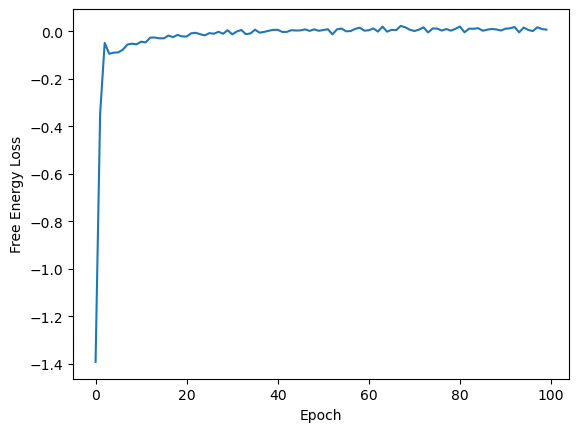

In [22]:
plt.plot([metrics[epoch]['loss_amp'] for epoch in metrics])
plt.xlabel("Epoch")
plt.ylabel("Free Energy Loss")

In [48]:
class PairPhaseRBM(nn.Module):
    n_visible: int
    n_hidden: int

    def setup(self):
        zeros = lambda shape: jnp.zeros(shape, dtype=jnp.float32)

        # Amplitude RBM (frozen parameters)
        self.W_amp = self.variable('amp_state', 'W_amp', zeros, (self.n_visible, self.n_hidden))
        self.b_amp = self.variable('amp_state', 'b_amp', zeros, (self.n_visible,))
        self.c_amp = self.variable('amp_state', 'c_amp', zeros, (self.n_hidden,))

        # Phase RBM (trainable parameters)
        self.W_pha = self.param('W_pha', nn.initializers.normal(0.01), (self.n_visible, self.n_hidden))
        self.b_pha = self.param('b_pha', nn.initializers.zeros, (self.n_visible,))
        self.c_pha = self.param('c_pha', nn.initializers.zeros, (self.n_hidden,))

        # Rotation matrices
        sqrt2 = jnp.sqrt(2.0)
        self.rotators = {
            'X': jnp.array([[1, 1], [1, -1]], dtype=jnp.complex64) / sqrt2,
            'Y': jnp.array([[1, -1j], [1, 1j]], dtype=jnp.complex64) / sqrt2,
        }

    @staticmethod
    def _free_energy(W, b, c, v):
        visible_term = jnp.dot(v, b)
        hidden_term = jnp.sum(jax.nn.softplus(jnp.dot(v, W) + c), axis=-1)
        return -visible_term - hidden_term

    @staticmethod
    def _free_energy_grad(W, b, c, v):
        pre = jnp.dot(v, W) + c
        sig = jax.nn.sigmoid(pre)
        dW = jnp.einsum('bi,bj->bij', v, sig)
        return jnp.concatenate([dW.reshape(v.shape[0], -1), v, sig], axis=1)

    def rotated_log_psi_and_grad(self, sigma_b, basis):
        W_amp, b_amp, c_amp = self.W_amp.value, self.b_amp.value, self.c_amp.value
        W_pha, b_pha, c_pha = self.W_pha, self.b_pha, self.c_pha

        B, n = sigma_b.shape
        non_z = [i for i, p in enumerate(basis) if p != 'Z']
        if len(non_z) != 2:
            raise ValueError("Basis must have exactly two non-Z qubits.")
        j, k = non_z

        Rj, Rk = self.rotators[basis[j]], self.rotators[basis[k]]
        U = jnp.kron(Rj, Rk)

        combos = jnp.array([[0., 0.], [0., 1.], [1., 0.], [1., 1.]], dtype=sigma_b.dtype)
        tiled = jnp.tile(sigma_b[:, None, :], (1, 4, 1))
        modified = tiled.at[:, :, [j, k]].set(combos[None, :, :])
        flat = modified.reshape(B * 4, n)

        F_amp = self._free_energy(W_amp, b_amp, c_amp, flat)
        F_pha = self._free_energy(W_pha, b_pha, c_pha, flat)

        log_mag = (-0.5 * F_amp).reshape(B, 4)
        angle = (-0.5 * F_pha).reshape(B, 4)
        M = jnp.max(log_mag, axis=1, keepdims=True)
        scaled = jnp.exp(log_mag - M + 1j * angle)

        idx = (sigma_b[:, j].astype(int) << 1) | sigma_b[:, k].astype(int)
        Uc = U[:, idx].T
        psi_rot = jnp.sum(Uc * scaled, axis=1)

        grad_F_amp = self._free_energy_grad(W_amp, b_amp, c_amp, flat).reshape(B, 4, -1)
        grad_F_pha = self._free_energy_grad(W_pha, b_pha, c_pha, flat).reshape(B, 4, -1)

        grad_logpsi = -0.5 * grad_F_amp + -0.5j * grad_F_pha
        psi_weighted_grad = jnp.einsum("bij,bi->bj", grad_logpsi, Uc * scaled)
        psi_ratio = psi_weighted_grad / (psi_rot[:, None] + 1e-12)

        split = grad_F_amp.shape[-1]
        grad_lambda = psi_ratio[:, :split].real
        grad_mu = -psi_ratio[:, split:].imag

        return grad_lambda, grad_mu, jnp.log(jnp.abs(psi_rot) + 1e-12), M.squeeze()

    def __call__(self, data_batch_dict):
        total_loss = 0.
        for basis, sigma_b in data_batch_dict.items():
            _, _, log_amp, M = self.rotated_log_psi_and_grad(sigma_b, basis)
            total_loss += -2. * jnp.mean(log_amp + M)
        return total_loss


In [49]:


@jax.jit
def train_step_pha(state: TrainState, amp_vars: Dict[str, jnp.ndarray], batch_dict: Dict[str, jnp.ndarray]) -> Tuple[TrainState, jnp.ndarray]:
    model_var_dict = { 'params': state.params, 'amp_state': amp_vars }
    def loss_fn(params):
        model_var_dict['params'] = params
        return state.apply_fn(model_var_dict, batch_dict)

    grads = {}
    loss = 0.0
    for basis, sigma_b in batch_dict.items():
        grad_lambda, grad_mu, log_amp, M = state.apply_fn(model_var_dict, method=PairPhaseRBM.rotated_log_psi_and_grad, sigma_b=sigma_b, basis=basis)
        loss += -2.0 * jnp.mean(log_amp + M)

        flat_mu = jnp.mean(grad_mu, axis=0)

        W_shape = state.params['W_pha'].shape
        b_shape = state.params['b_pha'].shape
        c_shape = state.params['c_pha'].shape

        import numpy as np
        nW = np.prod(W_shape)
        nb = np.prod(b_shape)
        nc = np.prod(c_shape)

        W_mu = flat_mu[:nW].reshape(W_shape)
        b_mu = flat_mu[nW:nW+nb].reshape(b_shape)
        c_mu = flat_mu[nW+nb:].reshape(c_shape)

        grads_basis = {
            'W_pha': W_mu,
            'b_pha': b_mu,
            'c_pha': c_mu
        }

        grads = jax.tree_util.tree_map(lambda g1, g2: g1 + g2, grads, grads_basis) if grads else grads_basis

    grads = jax.tree_util.tree_map(lambda g: g / len(batch_dict), grads)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss


def train_phase_rbm(state_pha: TrainState, amp_vars: Dict[str, jnp.ndarray], loader: MultiBasisDataLoader, num_epochs: int) -> Tuple[TrainState, Dict[int, float]]:
    metrics = {}
    for epoch in range(num_epochs):
        tot_loss = 0.0
        batches = 0
        for batch_dict in loader:
            state_pha, loss = train_step_pha(state_pha, amp_vars, batch_dict)
            tot_loss += loss
            batches += 1
        metrics[epoch] = {"loss_pha": float(tot_loss / batches)}
        print(f"Epoch {epoch+1}/{num_epochs} │ Loss: {metrics[epoch]['loss_pha']:.4f}")
    return state_pha, metrics

In [50]:
import optax, jax, jax.numpy as jnp
from typing import Any, NamedTuple

class NGDState(NamedTuple):
    pass  # No internal state for now

def natgrad_diag(damping: float = 1e-3) -> optax.GradientTransformation:
    def init_fn(params):
        return NGDState()

    def update_fn(updates, state, params=None):
        # Diagonal Fisher = square of the gradients
        nat_updates = jax.tree_map(
            lambda g: g / (jnp.square(g) + damping),
            updates
        )
        return nat_updates, state

    return optax.GradientTransformation(init_fn, update_fn)

In [51]:
batch_size    = 6400
lr            = 1e-3
num_epochs    = 50 # will be increased but currently no conclusive downwards trend


model_pha = PairPhaseRBM(n_visible=visible_units, n_hidden=hidden_units)
dummy_dict = next(iter(loader_pha))
variables_pha  = model_pha.init(rng, dummy_dict)

tx = optax.chain(
    natgrad_diag(damping=1e-3),
    optax.scale(-lr),  # standard gradient descent on natural step
)

state_pha = TrainState.create(
    apply_fn=model_pha.apply,
    params=variables_pha['params'],
    tx=tx,
)
#optimizer_pha = optax.adam(learning_rate=lr)
#state_pha = TrainState.create(apply_fn=model_pha.apply, params=variables_pha['params'], tx=optimizer_pha)

amp_vars = {
    'W_amp': state_amp.params['W'],
    'b_amp': state_amp.params['b'],
    'c_amp': state_amp.params['c'],
}
# These should be non-zero if amp RBM training was successful.

In [52]:
state_pha, metrics_pha = train_phase_rbm(
    state_pha=state_pha,
    amp_vars=amp_vars,
    loader=loader_pha,
    num_epochs=num_epochs
)

TypeError: cannot reshape array of shape (0,) (size 0) into shape (10, 10) (size 100)

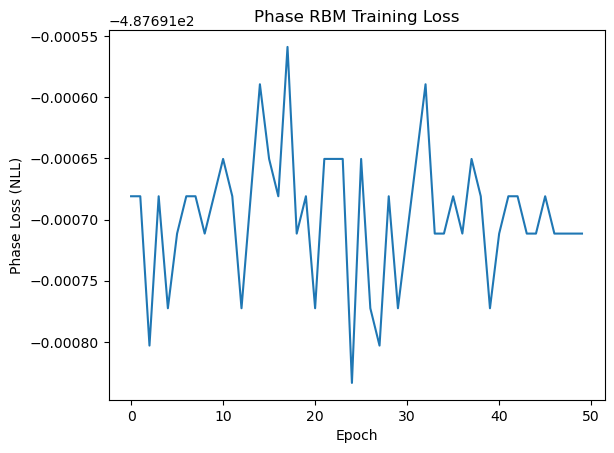

In [32]:
plt.plot([metrics_pha[e]['loss_pha'] for e in metrics_pha])
plt.xlabel("Epoch")
plt.ylabel("Phase Loss (NLL)")
plt.title("Phase RBM Training Loss")
plt.show()